# Arctic Ice Model for Regions in the Northern Hemisphere

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import io # file input

import matplotlib.pyplot as plt # plotting graphs
import seaborn as sns # not sure yet
from sklearn.linear_model import LinearRegression # for linear regression
%matplotlib inline
plt.style.use('ggplot')

import plotly.express as px

# Upload file during compilation
# This may not be the best way to import a csv file to colab but it's
# the most straight forward way I've found 
from google.colab import files
uploaded = files.upload()

Saving masie_4km_allyears_extent_sqkm.csv to masie_4km_allyears_extent_sqkm.csv


In [2]:
df = pd.read_csv(io.BytesIO(uploaded['masie_4km_allyears_extent_sqkm.csv']))
df.dataframeName = '4sqkm MASIE Regions'
df1 = df.iloc[:, 1:].copy()
df.head(10)


,yyyyddd,Northern_Hemisphere,Beaufort_Sea,Chukchi_Sea,East_Siberian_Sea,Laptev_Sea,Kara_Sea,Barents_Sea,Greenland_Sea,Baffin_Bay_Gulf_of_St._Lawrence,Canadian_Archipelago,Hudson_Bay,Central_Arctic,Bering_Sea,Baltic_Sea,Sea_of_Okhotsk,Yellow_Sea,Cook_Inlet
0,2006001,13034723.95,1069710.81,966006.16,1087102.72,897773.37,901663.34,432629.77,550158.41,831365.98,852715.31,1260715.19,3225371.74,639590.07,11408.53,287369.54,12152.54,6420.96
1,2006002,13034723.95,1069710.81,966006.16,1087102.72,897773.37,901663.34,432629.77,550158.41,831365.98,852715.31,1260715.19,3225371.74,639590.07,11408.53,287369.54,12152.54,6420.96
2,2006003,13170663.24,1069710.81,966006.16,1087102.72,897773.37,901663.34,432629.77,595342.42,855907.47,852715.31,1260779.00,3240507.71,666030.40,11408.53,311943.21,12152.54,6420.96
3,2006004,13409715.53,1069710.81,966006.16,1087102.72,897773.37,906439.04,458823.88,605747.86,980253.85,852715.31,1260779.00,3240326.47,683780.08,11408.53,372868.02,6989.96,6420.96
4,2006005,13416779.12,1069710.81,966006.16,1087102.72,897773.37,908697.29,474574.82,600826.71,970631.09,852715.31,1260779.00,3240326.47,683795.38,21311.46,363515.34,8240.73,8202.95
5,2006006,13465566.44,1069710.81,966006.16,1087102.72,897773.37,909717.79,474574.82,595938.39,992651.97,852715.31,1260779.00,3240326.47,685430.49,21327.46,385908.77,14830.45,8202.95
6,2006007,13510769.37,1069710.81,966006.16,1087102.72,897773.37,927602.17,474574.82,588978.00,1000360.27,852715.31,1260779.00,3240326.47,690278.54,21327.46,407631.37,14830.45,8202.95
7,2006008,13536736.84,1069710.81,966006.16,1087102.72,897773.37,927602.17,474574.82,590029.18,1005790.38,852715.31,1260779.00,3240326.47,692832.54,21327.46,424563.54,14830.45,8202.95
8,2006009,13536887.64,1069710.81,966006.16,1087102.72,897773.37,927602.17,474574.82,590029.18,1005790.38,852715.31,1260779.00,3240326.47,692832.54,21478.25,424563.54,14830.45,8202.95
9,2006010,13505426.35,1069710.81,966006.16,1087102.72,897773.37,933999.29,448185.27,588279.64,1016857.87,852715.31,1260779.00,3217380.82,705348.17,21493.81,414191.19,14830.45,8202.95


###Helper functions to plot different graphs

Code found on kaggle at https://www.kaggle.com/code/kerneler/starter-ims-daily-northern-hemisphere-d4fe59c3-c/notebook

In [3]:
# Correclation Matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [4]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [5]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    # This may need to change, most columns should have more than 50 unique values
    # df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    df = df[[col for col in df if nunique[col] > 1]]
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

##What Data do we Have? 

Given a year (from 2006 to 2021) and day (from 1 to 365) each location has an ice extent value **(find units)**

These locations are 4km by 4km areas around the Arctic Circle 

## How is our Data Measured?

Need paragraph about the sensors used to measure this data, found online

# Split up each region in our dataset to compute individual models

In [6]:
# Give a time set to create other graphs with
time_set = df.yyyyddd

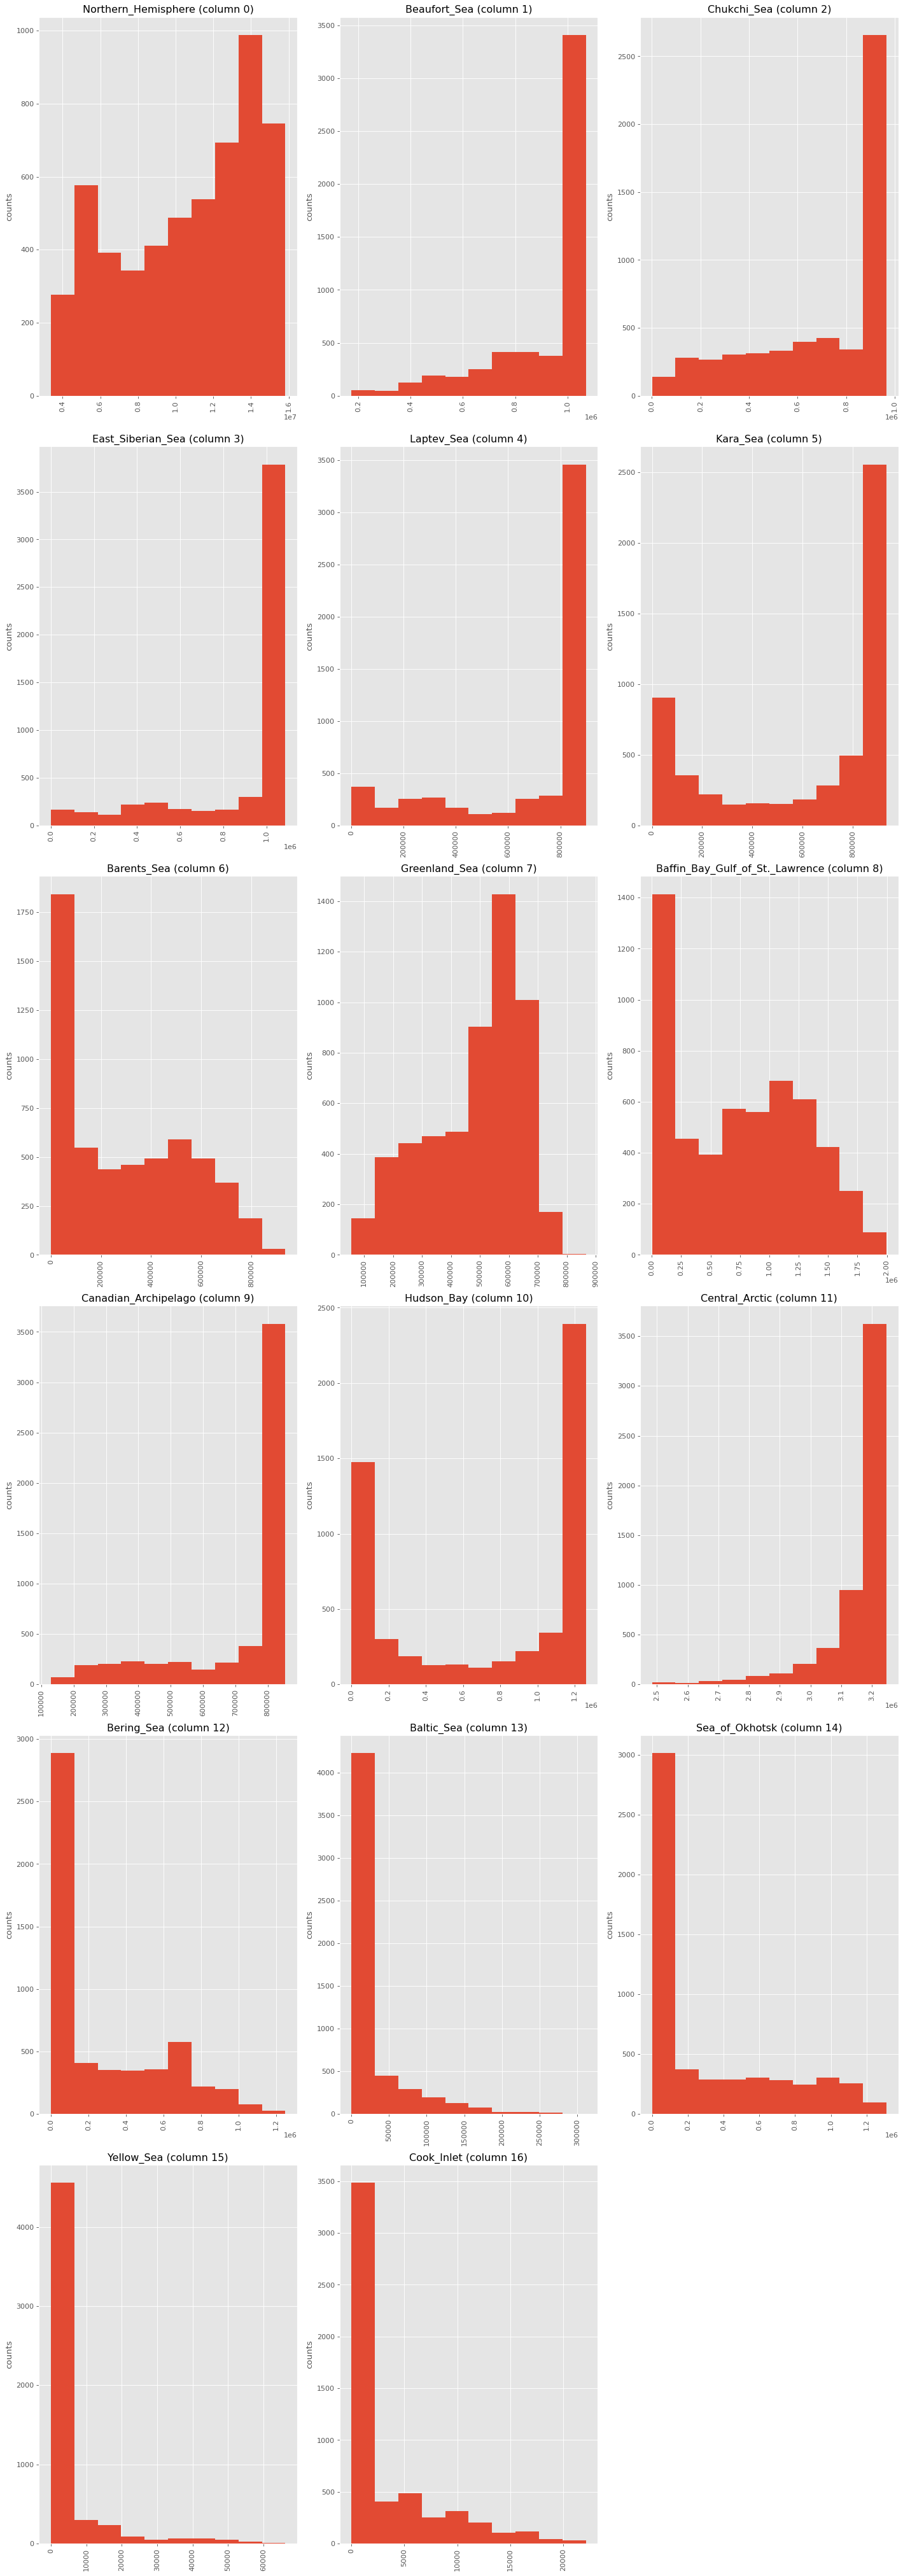

In [7]:
plotPerColumnDistribution(df1, 18, 3)

<ipython-input-3-aa4657a710f0>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  df = df.dropna('columns') # drop columns with NaN


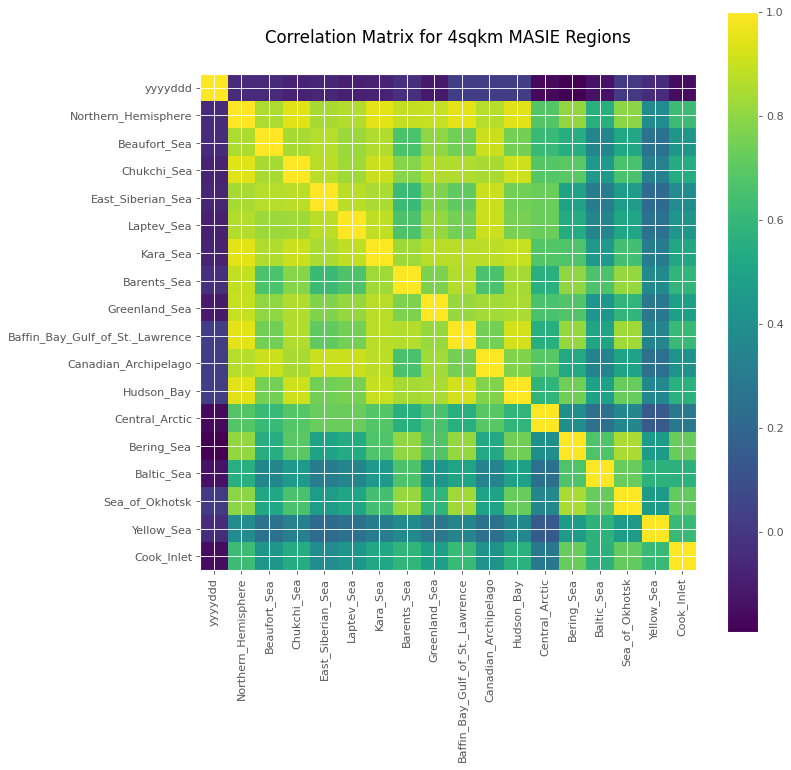

In [8]:
plotCorrelationMatrix(df, 10)

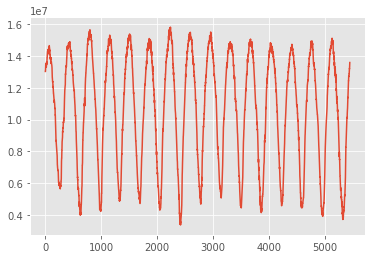

In [9]:
df.Northern_Hemisphere.plot()

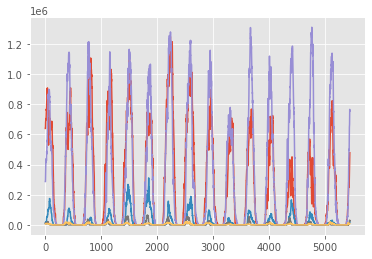

In [10]:
# When looking at a correlation matrix these correlate least with other regions
# this is because these regions have no ice in the summer months as seen when they
# hit zero throughout part of the year

df.Bering_Sea.plot()
df.Baltic_Sea.plot()
df.Sea_of_Okhotsk.plot()
df.Yellow_Sea.plot()
df.Cook_Inlet.plot()

Linear Least Squares Function


In [11]:
def lls(location_name):
  # Let's do some least squares!
  # We need some data points
  one = df[location_name].to_numpy()
  #print(one)
  #print(time_set)
  a = []
  for i in range(0,5450):
    a.append(i)
  t = np.array(a)
  b = np.array(one)
  '''plt.plot(t, b, 'o', label='Og data', markersize = 2)
  plt.legend()
  plt.show()
  '''
  # These do not make a line
  # first make the A matrix
  A =  np.vstack([t, np.ones(len(t))]).T
  print("A matrix -", A, '\n')
  # solve for our x_hat (the slope and intercept of the line)
  '''
  x_hat = np.linalg.inv(A.T@A)@A.T@b
  print(x_hat, '\n')
  plt.plot(t, b, 'o', label='Og data', markersize = 2)
  plt.plot(t, x_hat[0]*t + x_hat[1], 'r', label='LS fit')
  plt.legend()
  plt.show()
  '''
  # numpy fancy function to do the same thing but better
  m, s = np.linalg.lstsq(A, b, rcond=None)[0]
  print("Slope of line: ", m)
  print("Y-intercept: ", s)
  plt.plot(t, b, 'o', label='Og data', markersize = 2)
  plt.plot(t, m*t + s, 'r', label='LS fit')
  plt.legend()
  plt.show()

In [12]:
df.head(0)
location_list=["Northern_Hemisphere","Beaufort_Sea","Chukchi_Sea","East_Siberian_Sea","Laptev_Sea","Kara_Sea","Barents_Sea","Greenland_Sea","Baffin_Bay_Gulf_of_St._Lawrence","Canadian_Archipelago","Hudson_Bay","Central_Arctic","Bering_Sea","Baltic_Sea","Sea_of_Okhotsk","Yellow_Sea","Cook_Inlet"]

All location's LLS regression

Northern_Hemisphere linear least squares regression
A matrix - [[0.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [2.000e+00 1.000e+00]
 ...
 [5.447e+03 1.000e+00]
 [5.448e+03 1.000e+00]
 [5.449e+03 1.000e+00]] 

Slope of line:  -175.3199801108963
Y-intercept:  11130734.690333232


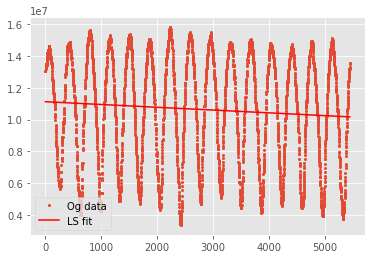

--------------------------------------------
Beaufort_Sea linear least squares regression
A matrix - [[0.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [2.000e+00 1.000e+00]
 ...
 [5.447e+03 1.000e+00]
 [5.448e+03 1.000e+00]
 [5.449e+03 1.000e+00]] 

Slope of line:  -8.365431169679558
Y-intercept:  954053.802605278


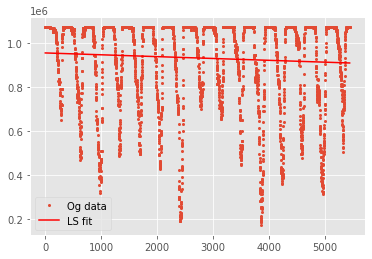

--------------------------------------------
Chukchi_Sea linear least squares regression
A matrix - [[0.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [2.000e+00 1.000e+00]
 ...
 [5.447e+03 1.000e+00]
 [5.448e+03 1.000e+00]
 [5.449e+03 1.000e+00]] 

Slope of line:  -18.813099862236665
Y-intercept:  767111.5913893427


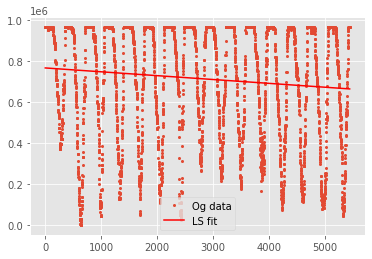

--------------------------------------------
East_Siberian_Sea linear least squares regression
A matrix - [[0.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [2.000e+00 1.000e+00]
 ...
 [5.447e+03 1.000e+00]
 [5.448e+03 1.000e+00]
 [5.449e+03 1.000e+00]] 

Slope of line:  -15.657668512985637
Y-intercept:  952616.9485039965


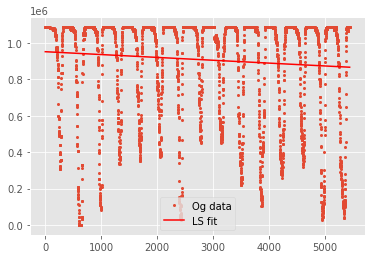

--------------------------------------------
Laptev_Sea linear least squares regression
A matrix - [[0.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [2.000e+00 1.000e+00]
 ...
 [5.447e+03 1.000e+00]
 [5.448e+03 1.000e+00]
 [5.449e+03 1.000e+00]] 

Slope of line:  -19.431774154331766
Y-intercept:  757000.5894522842


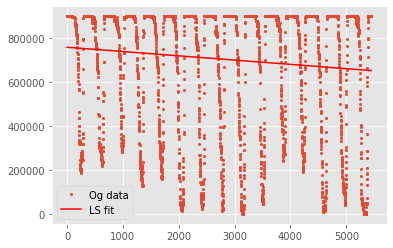

--------------------------------------------
Kara_Sea linear least squares regression
A matrix - [[0.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [2.000e+00 1.000e+00]
 ...
 [5.447e+03 1.000e+00]
 [5.448e+03 1.000e+00]
 [5.449e+03 1.000e+00]] 

Slope of line:  -21.39151098345622
Y-intercept:  673760.6130248851


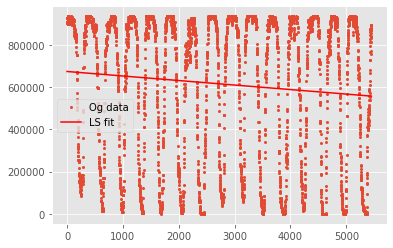

--------------------------------------------
Barents_Sea linear least squares regression
A matrix - [[0.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [2.000e+00 1.000e+00]
 ...
 [5.447e+03 1.000e+00]
 [5.448e+03 1.000e+00]
 [5.449e+03 1.000e+00]] 

Slope of line:  -9.868961979339748
Y-intercept:  324377.03353656427


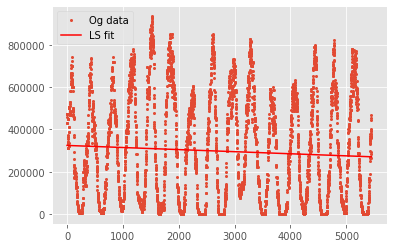

--------------------------------------------
Greenland_Sea linear least squares regression
A matrix - [[0.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [2.000e+00 1.000e+00]
 ...
 [5.447e+03 1.000e+00]
 [5.448e+03 1.000e+00]
 [5.449e+03 1.000e+00]] 

Slope of line:  -13.160810927653593
Y-intercept:  522498.4359852362


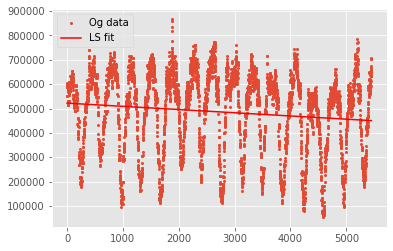

--------------------------------------------
Baffin_Bay_Gulf_of_St._Lawrence linear least squares regression
A matrix - [[0.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [2.000e+00 1.000e+00]
 ...
 [5.447e+03 1.000e+00]
 [5.448e+03 1.000e+00]
 [5.449e+03 1.000e+00]] 

Slope of line:  -0.8000902124294657
Y-intercept:  754078.0931911038


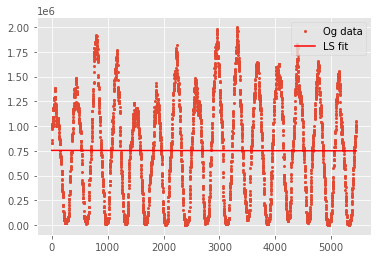

--------------------------------------------
Canadian_Archipelago linear least squares regression
A matrix - [[0.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [2.000e+00 1.000e+00]
 ...
 [5.447e+03 1.000e+00]
 [5.448e+03 1.000e+00]
 [5.449e+03 1.000e+00]] 

Slope of line:  1.89819204774033
Y-intercept:  721503.3482319866


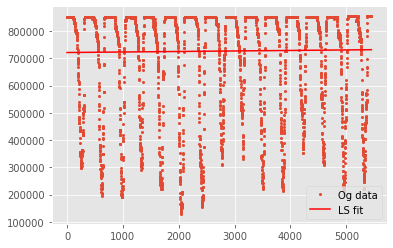

--------------------------------------------
Hudson_Bay linear least squares regression
A matrix - [[0.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [2.000e+00 1.000e+00]
 ...
 [5.447e+03 1.000e+00]
 [5.448e+03 1.000e+00]
 [5.449e+03 1.000e+00]] 

Slope of line:  -0.11619484794323026
Y-intercept:  744878.8245035884


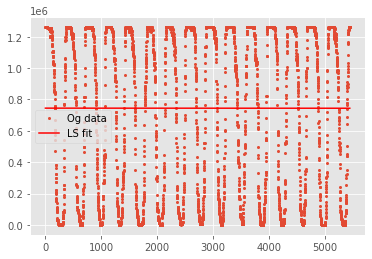

--------------------------------------------
Central_Arctic linear least squares regression
A matrix - [[0.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [2.000e+00 1.000e+00]
 ...
 [5.447e+03 1.000e+00]
 [5.448e+03 1.000e+00]
 [5.449e+03 1.000e+00]] 

Slope of line:  -12.846292733025948
Y-intercept:  3198802.605784157


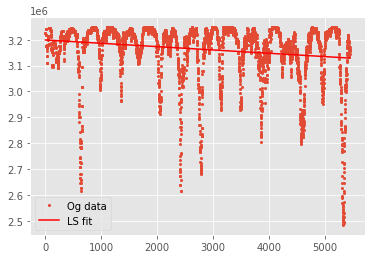

--------------------------------------------
Bering_Sea linear least squares regression
A matrix - [[0.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [2.000e+00 1.000e+00]
 ...
 [5.447e+03 1.000e+00]
 [5.448e+03 1.000e+00]
 [5.449e+03 1.000e+00]] 

Slope of line:  -44.78241097816808
Y-intercept:  389085.8288035969


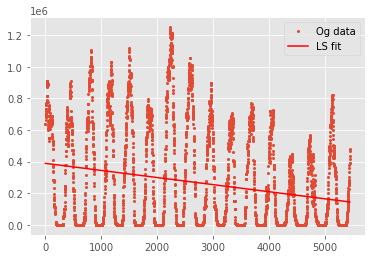

--------------------------------------------
Baltic_Sea linear least squares regression
A matrix - [[0.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [2.000e+00 1.000e+00]
 ...
 [5.447e+03 1.000e+00]
 [5.448e+03 1.000e+00]
 [5.449e+03 1.000e+00]] 

Slope of line:  -4.480737252393373
Y-intercept:  35808.89055790721


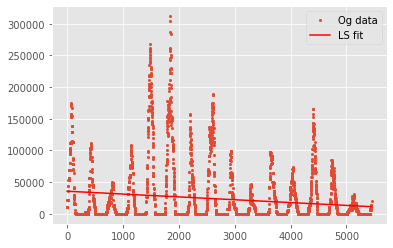

--------------------------------------------
Sea_of_Okhotsk linear least squares regression
A matrix - [[0.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [2.000e+00 1.000e+00]
 ...
 [5.447e+03 1.000e+00]
 [5.448e+03 1.000e+00]
 [5.449e+03 1.000e+00]] 

Slope of line:  -5.313452146965166
Y-intercept:  316326.5260918377


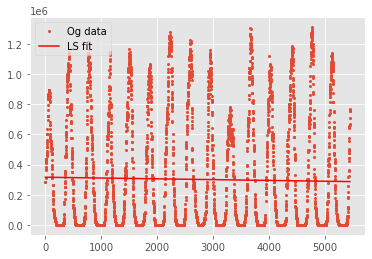

--------------------------------------------
Yellow_Sea linear least squares regression
A matrix - [[0.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [2.000e+00 1.000e+00]
 ...
 [5.447e+03 1.000e+00]
 [5.448e+03 1.000e+00]
 [5.449e+03 1.000e+00]] 

Slope of line:  -0.4028715766240914
Y-intercept:  4973.635577484814


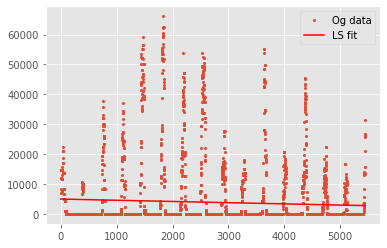

--------------------------------------------
Cook_Inlet linear least squares regression
A matrix - [[0.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [2.000e+00 1.000e+00]
 ...
 [5.447e+03 1.000e+00]
 [5.448e+03 1.000e+00]
 [5.449e+03 1.000e+00]] 

Slope of line:  -0.5334497833668975
Y-intercept:  4592.932305425315


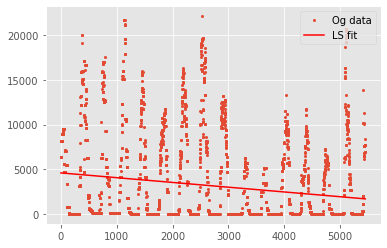

--------------------------------------------


In [13]:
for location in location_list:
  print(location, "linear least squares regression")
  lls(location)
  print("--------------------------------------------")

In [14]:
prediction_list = ["Northern_Hemisphere", "Canadian_Archipelago", "Hudson_Bay", "Bering_Sea"]

Northern Hemisphere January LLS
Slope of line:  -226.1318856162879
Y-intercept:  13840085.67785195


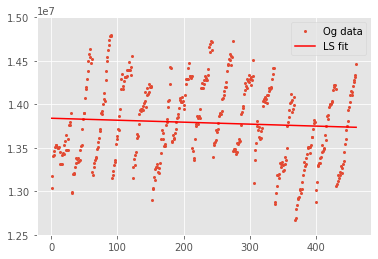

Canadian Archipelago January LLS
Slope of line:  2.339846157734165
Y-intercept:  852581.2912432514


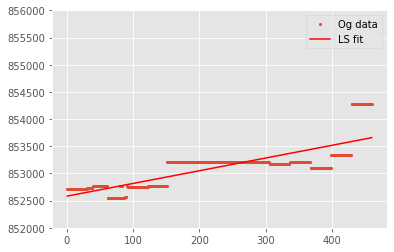

Hudson Bay January LLS
Slope of line:  30.70507271280399
Y-intercept:  1246141.9786092646


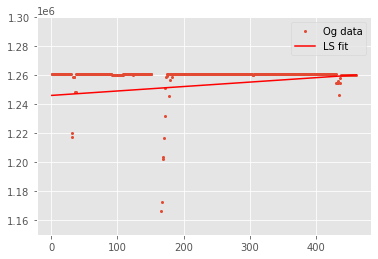

Bering Sea January LLS
Slope of line:  -798.1122155574419
Y-intercept:  742523.5092077298


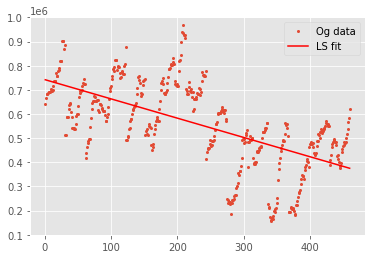

January Predictions per Location
----------------------------------------
Northern Hemisphere: 13732220.76841298
13697230.201612901
Canadian Archipelago: 853697.3978604904
854282.4200000007
Hudson Bay: 1260788.298293272
1258825.2467741924
Bering Sea: 361823.98238683
468541.80548387096

Percentage change from previous year's January
----------------------------------------
Northern Hemisphere:0.25545724416574456% change
Canadian Archipelago:-0.06848111652705813% change
Hudson Bay:0.15594313222665535% change
Bering Sea:-22.77658510894918% change


In [15]:
def jan_lls(location_set, time_set,lower_scale,scale):
  print
  # Let's do some least squares!
  # We need some data points
  # one = df[location_name].to_numpy()
  #print(one)
  #print(time_set)
  a_lst = []
  b_lst = []
  t_count = 1
    # print(len(location_set))
  # Length is 5450 but we don't want to consider the last 14 days due to our 
  # data ending on January 14th
  # By making this change we have cut the slope of the Northern Hemisphere data
  # by almost 50%. This leads to a much more accurate linear least squares line
  for i in range(1, len(location_set) - 14):
    if int(str(time_set[i])[-3:]) <= 31:
      # print(str(time_set[i])[-3:])
      a_lst.append(t_count)
      t_count += 1
      b_lst.append(location_set[i])
  t = np.array(a_lst)
  b = np.array(b_lst)

  previous_month_average = sum(b_lst[-31:])/31
  '''plt.plot(t, b, 'o', label='Og data', markersize = 2)
  plt.legend()
  plt.show()
  '''
  # These do not make a line
  # first make the A matrix
  A =  np.vstack([t, np.ones(len(t))]).T
  # print("A matrix -", A, '\n')
  # solve for our x_hat (the slope and intercept of the line)
  '''
  x_hat = np.linalg.inv(A.T@A)@A.T@b
  print(x_hat, '\n')
  plt.plot(t, b, 'o', label='Og data', markersize = 2)
  plt.plot(t, x_hat[0]*t + x_hat[1], 'r', label='LS fit')
  plt.legend()
  plt.show()
  '''
  # numpy fancy function to do the same thing but better
  m, s = np.linalg.lstsq(A, b, rcond=None)[0]
  print("Slope of line: ", m)
  print("Y-intercept: ", s)
  plt.ylim([lower_scale,scale])
  plt.plot(t, b, 'o', label='Og data', markersize = 2)
  plt.plot(t, m*t + s, 'r', label='LS fit')
  plt.legend()
  plt.show()
  return previous_month_average
print("Northern Hemisphere January LLS")
last_month_NH = jan_lls(df.Northern_Hemisphere.to_list(), time_set.to_list(),12500000,15000000)
print("Canadian Archipelago January LLS")
last_month_CA = jan_lls(df.Canadian_Archipelago.to_list(), time_set.to_list(), 852000,856000)
print("Hudson Bay January LLS")
last_month_HB = jan_lls(df.Hudson_Bay.to_list(), time_set.to_list(),1150000,1300000)
print("Bering Sea January LLS")
last_month_BS = jan_lls(df.Bering_Sea.to_list(), time_set.to_list(),100000,1000000)
def predict(slope,yint):
  lst=[]
  for i in range(1,32):
    lst.append(yint+(slope*(461+i)))
  avg = (sum(lst))/(len(lst))
  return avg
north = predict(-226.1318856162879,13840085.67785195)
can = predict(2.339846157734165,852581.2912432514)
huds = predict(30.70507271280399,1246141.9786092646)
ber = predict(-798.1122155574419,742523.5092077298)
print("January Predictions per Location")
print("----------------------------------------")
print("Northern Hemisphere:", north)
print(last_month_NH)
print("Canadian Archipelago:", can)
print(last_month_CA)
print("Hudson Bay:", huds)
print(last_month_HB)
print("Bering Sea:", ber)
print(last_month_BS)
print("")
print("Percentage change from previous year's January")
print("----------------------------------------")
n = (north - last_month_NH)/(last_month_NH)
print("Northern Hemisphere:" + str(n*100)+"% change")
c = (can-last_month_CA)/(last_month_CA)
print("Canadian Archipelago:"+ str(c*100)+"% change")
h = (huds-last_month_HB)/(last_month_HB)
print("Hudson Bay:" + str(h*100)+"% change")
b = (ber -last_month_BS)/(last_month_BS)
print("Bering Sea:" + str(b*100)+"% change")

